In [1]:
%load_ext autoreload
%autoreload 2

import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tqdm.notebook import tqdm
from numba import jit

import EOT.EOT as eot
import EOT.costs as costs
import EOT.utils as utils

sns.set_theme(style="darkgrid")

In [2]:
n_float = 2
np.set_printoptions(n_float)
COLORS = ['tab:green', 'tab:purple', 'tab:orange']

In [3]:
##### generate ressources 
num_samples = 6
X, Y = utils.simul_two_Gaussians(num_samples)
a = (1 / num_samples) * np.ones(num_samples)
b = (1 / num_samples) * np.ones(num_samples)


#### generate costs
C1 = costs.Square_Euclidean_Distance(X, Y)
C2 = costs.alpha_Euclidean_Distance(X, Y, alpha=2.2) #square cost a la puissance alpha
C3 = costs.Trivial_cost(X, Y) # 0 si x=y et 1 sinon

C = np.zeros((3, num_samples, num_samples))
C[0, :, :] = C1
C[1, :, :] = C2
C[2, :, :] = C3
C[:,:,:]*=1

if True :
    for i, cost_matrix in enumerate(C):
        size_matrix = 1 + num_samples*(4+n_float)
        print(f"{f'Cost Matrix Agent {i}':^{size_matrix}}\n")
        print(cost_matrix, "\n")

         Cost Matrix Agent 0         

[[ 0.14  1.02  9.22  3.57  2.13  1.29]
 [ 1.82  6.86 16.85  9.88  0.55  5.85]
 [ 6.92 15.   23.26 16.51  3.74 11.77]
 [ 3.17  9.15 23.93 14.95  0.49  9.69]
 [ 9.17  9.54  1.81  2.42 13.94  3.35]
 [ 6.65 10.32  7.06  5.44  8.38  4.4 ]] 

         Cost Matrix Agent 1         

[[ 0.12  1.02 11.52  4.05  2.3   1.32]
 [ 1.94  8.32 22.34 12.42  0.52  6.98]
 [ 8.4  19.66 31.86 21.85  4.26 15.06]
 [ 3.55 11.41 32.87 19.6   0.46 12.16]
 [11.44 11.95  1.92  2.64 18.14  3.78]
 [ 8.04 13.03  8.59  6.45 10.36  5.1 ]] 

         Cost Matrix Agent 2         

[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]] 



/Users/guillaume/Projets/OT_DM/EOT/EOT.py:72: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, C))
  lam_trans[i] = np.dot(k_lam_trans, beta)


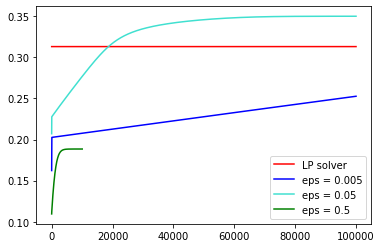

In [4]:
### test the accuracy of the algo compared to LP solver
if True :
    utils.plot_accuracy_algorithm(C, a, b)

In [4]:
def gen_word(num_samples):
    X, Y = utils.simul_two_Gaussians(num_samples)
    a = (1 / num_samples) * np.ones(num_samples)
    return X, Y, a, a

In [5]:
def run_simu_2(num_samples, num_agents, max_iter=50000, val_min=0, val_max=1, eps=5e-3):
    """Simulation de l'algorithme avec des signes fixes pour tous les agents"""
    
    assert np.exp(val_max/eps) < float('inf'), 'val max is too high with respect to eps'
    
    # Génération des points et des poids associés
    X, Y, a, b = gen_word(num_samples)
    
    # Génération des coûts
    C = np.random.uniform(val_min, val_max, (num_agents, num_samples, num_samples))
    
    # Génération des signes des couts
    C_signes = np.random.choice([-1, 1], (num_samples, num_samples))
    for i, c in enumerate(C):
        C[i] = np.multiply(c, C_signes)
        
    # Run algo
    return X, Y, C, eot.EOT_PSinkhorn(C, eps, a, b)

In [6]:
def res_cost(res_run_simu_2):
    """Results on costs"""
    X, Y, C, all_res = res_run_simu_2
    alpha, beta, denom, _, K_trans = all_res[3:] 

    couplings = (alpha[:, np.newaxis] * K_trans * beta[np.newaxis, :]) / denom
    price = np.array(utils.price_of_players(C, couplings))

    num_same = np.isclose(price, np.amax(price), rtol=0.01).sum()
    diff = np.abs(price.max() - price.min())

    return num_same, diff

In [66]:
num_samples = 20
num_agents = 20
num_simu = 100

simulations = [run_simu_2(num_samples, num_agents) for _ in tqdm(range(num_simu))]
res = np.array([res_cost(res) for res in simulations])

  0%|          | 0/100 [00:00<?, ?it/s]

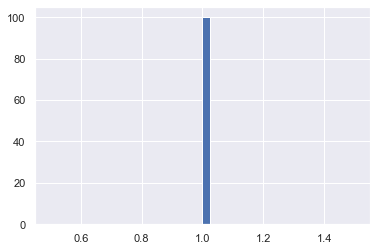

In [67]:
plt.hist(res[:,0]/num_agents, 40)
plt.show()

In [62]:
num_samples = 50
num_agents = 3
num_simu = 100

simulations_samples = [run_simu_2(num_samples, num_agents) for _ in tqdm(range(num_simu))]
res_samples = np.array([res_cost(res) for res in simulations_samples])

  0%|          | 0/100 [00:00<?, ?it/s]

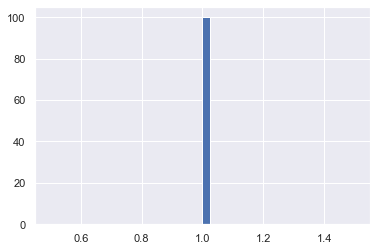

In [63]:
plt.hist(res_samples[:,0]/num_agents, 40)
plt.show()

In [64]:
num_samples = 3
num_agents = 50
num_simu = 100

simulations_agents = [run_simu_2(num_samples, num_agents) for _ in tqdm(range(num_simu))]
res_agents = np.array([res_cost(res) for res in simulations_agents])

  0%|          | 0/100 [00:00<?, ?it/s]

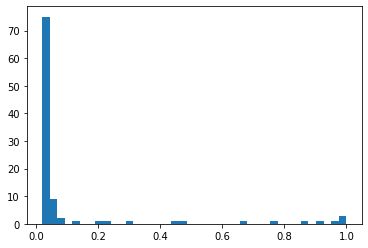

In [12]:
plt.hist(res_agents[:,0]/num_agents, 40)
plt.show()

In [76]:
num_simu = 10

list_num_samples = range(3, 10)
res = []

for num_samples in tqdm(list_num_samples):
    list_num_agents = np.array([int(x) for x in np.linspace(1, 20, 10)])*num_samples
    for num_agents in tqdm(list_num_agents, leave=False):
        simulations_all = [run_simu_2(num_samples, num_agents) for _ in range(num_simu)]
        res_simu_all = np.array([res_cost(res) for res in simulations_all])
        res.append(np.array([res_simu_all[:,0], [num_agents]*len(simulations_all), [num_samples]*len(simulations_all)]).T)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [83]:
df = pd.DataFrame(np.vstack(res*2), columns=['car_I', 'num_agents', 'num_samples'])


df['frac_car_I'] = df.car_I / df.num_agents
df['frac_agents_samples'] = df.num_agents/df.num_samples
df['frac_samples_agents'] = df.num_samples/df.num_agents

In [93]:
df.to_csv('data.csv')

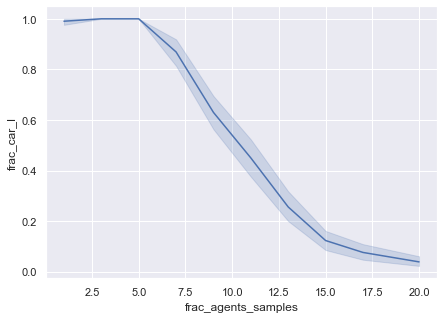

In [100]:
# Plot the responses for different events and regions
sns.set(rc={'figure.figsize':(7,5)})
sns.lineplot(x="frac_agents_samples", y="frac_car_I",
             data=df)
plt.savefig('fig1.png', dpi=150)

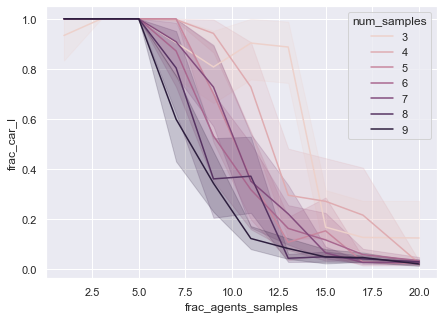

In [101]:
# Plot the responses for different events and regions
sns.lineplot(x="frac_agents_samples", y="frac_car_I", hue="num_samples",
             data=df)
plt.savefig('fig2.png', dpi=150)

In [68]:
df.num_agents.unique()

array([19.])

In [77]:
num_agents = 4
num_samples = 10

simulations_all = [run_simu_2(num_samples, num_agents) for _ in range(num_simu)]
diff = [diff_prc_simu_2(res) for res in simulations_all]

In [82]:
res.append([diff, [num_agents]*len(simulations_all), [num_samples]*len(simulations_all)])

In [83]:
l = np.array(res).T

In [84]:
m = np.array(res2).T

In [88]:
np.vstack((l,m)).shape

(200, 3)

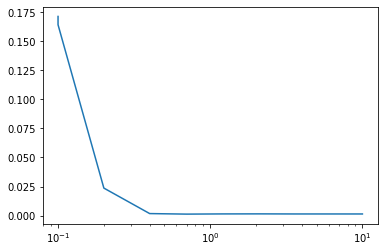

In [65]:
plt.plot(np.array(list_num_samples)/num_agents, diff_res_all_samples)
plt.xscale('log')
plt.show()

In [63]:
res_pb = simulations[s[-1]]

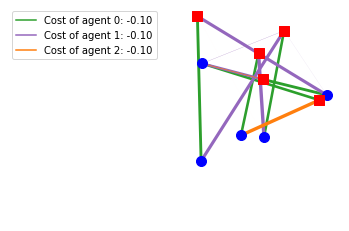

In [12]:
X, Y, C, all_res = res_pb
alpha, beta, denom, _, K_trans = all_res[3:] 

couplings = (alpha[:, np.newaxis] * K_trans * beta[np.newaxis, :]) / denom

utils.print_ot_and_cost(X, Y, couplings, C)

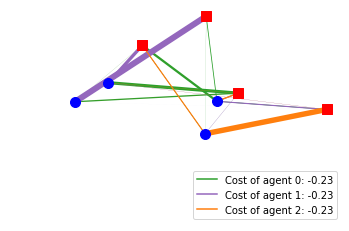

In [13]:
num_samples = 4

X, Y = utils.simul_two_Gaussians(num_samples)
a, b = (1 / num_samples) * np.ones(num_samples), (1 / num_samples) * np.ones(
    num_samples)

C1 = np.random.uniform(0,1,(num_samples,num_samples))
C2 = np.random.uniform(0,1,(num_samples,num_samples)) #square cost a la puissance alpha
C3 = np.random.uniform(0,1,(num_samples,num_samples)) # 0 si x=y et 1 sinon

Cp1 = np.sign(np.random.uniform(-1,1,(num_samples,num_samples)))
Cp2 = np.sign(np.random.uniform(-1,1,(num_samples,num_samples)))
Cp3 = np.sign(np.random.uniform(-1,1,(num_samples,num_samples)))

C = np.zeros((3, num_samples, num_samples))
C[0, :, :] = np.multiply(C1,Cp1)
C[1, :, :] = np.multiply(C2,Cp2)
C[2, :, :] = np.multiply(C3,Cp3)
C[:,0,:]*=1

if False :
    for i, cost_matrix in enumerate(C):
        size_matrix = 1 + num_samples*(4+n_float)
        print(f"{f'Cost Matrix Agent {i}':^{size_matrix}}\n")
        print(cost_matrix, "\n")

# run the algo avec reg (epsilon) de 10**-3
reg = 5 * 1e-2
res, acc, lam, alpha, beta, denom, KC, K_trans = eot.EOT_PSinkhorn(C, reg, a, b)
# compute P and check that P satisfies the marginal constraints
#plt.plot(acc)
#plt.show()
couplings = (alpha[:, np.newaxis] * K_trans * beta[np.newaxis, :]) / denom

utils.print_ot_and_cost(X, Y, couplings, C)

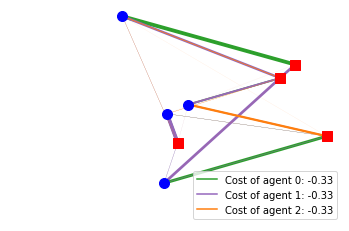

In [14]:
num_samples = 4

X, Y = utils.simul_two_Gaussians(num_samples)
a, b = (1 / num_samples) * np.ones(num_samples), (1 / num_samples) * np.ones(
    num_samples)

C1 = np.random.uniform(0,1,(num_samples,num_samples))
C2 = np.random.uniform(0,1,(num_samples,num_samples)) #square cost a la puissance alpha
C3 = np.random.uniform(0,1,(num_samples,num_samples)) # 0 si x=y et 1 sinon

Cp1 = np.sign(np.random.uniform(-1,1,(num_samples,num_samples)))
Cp2 = np.sign(np.random.uniform(-1,1,(num_samples,num_samples)))
Cp3 = np.sign(np.random.uniform(-1,1,(num_samples,num_samples)))

C = np.zeros((3, num_samples, num_samples))
C[0, :, :] = np.multiply(C1,Cp1)
C[1, :, :] = np.multiply(C2,Cp2)
C[2, :, :] = C3*-3
C[:,0,:]*=1

if False :
    for i, cost_matrix in enumerate(C):
        size_matrix = 1 + num_samples*(4+n_float)
        print(f"{f'Cost Matrix Agent {i}':^{size_matrix}}\n")
        print(cost_matrix, "\n")

# run the algo avec reg (epsilon) de 10**-3
reg = 5 * 1e-2
max_iter = 4000
res, acc, lam, alpha, beta, denom, KC, K_trans = eot.EOT_PSinkhorn(C, reg, a, b)
# compute P and check that P satisfies the marginal constraints
#plt.plot(acc)
#plt.show()
couplings = (alpha[:, np.newaxis] * K_trans * beta[np.newaxis, :]) / denom

utils.print_ot_and_cost(X, Y, couplings, C)

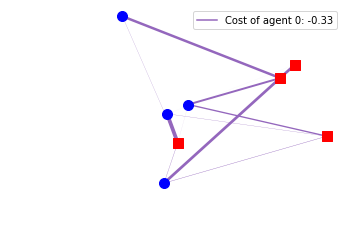

In [15]:
agent = 1
utils.print_ot_and_cost(X, Y, couplings, C, agent)

## BONUS

In [15]:
## Accelerated  PGD method
max_iter = 2000 # ne marche pas pour plus d'itérations !!!

reg_m = 5 * 1e-2
res_m, acc_m, times_m, lam_m, alpha_m, beta_m, denom_m, KC_m, K_trans_m = eot.EOT_APGD(C, reg_m, a, b, max_iter=max_iter)

reg_mm = 5* 1e-1
res_mm, acc_mm, times_m, lam_mm, alpha_mm, beta_mm, denom_mm, KC_mm, K_trans_mm = eot.EOT_APGD(C, reg_mm, a, b, max_iter=max_iter)

reg = 5 * 1e-3
res, acc, times_m, lam, alpha, beta, denom, KC, K_trans = eot.EOT_APGD(C, reg, a, b, max_iter=max_iter)

res_prim = eot.LP_solver_Primal(C, a, b)

eps = 1e-2
couplings = (alpha[:, np.newaxis] * K_trans * beta[np.newaxis, :]) / denom

P1, P2, P3 = couplings
P = P1 + P2 + P3
# check that P satisfies the marginal constraints
#assert (np.sum(P, axis=0) - a < eps).all()
#assert (np.sum(P, axis=1) - b < eps).all()


plt.plot([res_prim["fun"]]*max_iter, c = "red", label = "LP solver")
plt.plot(acc,c="blue",label = "eps = 0.005")
plt.plot(acc_m,c="turquoise",label = "eps = 0.05")
plt.plot(acc_mm,c="green",label = "eps = 0.5")
plt.legend()
plt.show()

AttributeError: module 'EOT.EOT' has no attribute 'EOT_APGD'

In [ ]:
# Compute the primal formulation of the entropic EOT
res_primal = eot.compute_EOT_primal(lam, alpha, beta, KC, denom, reg, a, b)

print(res_primal)